<a href="https://colab.research.google.com/github/johnnyff/tobigs16/blob/master/week7_assignment/Week7_cnnmodel_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

data_dir = '/content/drive/MyDrive/tobigs/week7/data/'

# 데이터 확인

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

데이터 출처: https://github.com/zalandoresearch/fashion-mnist

In [3]:
Train = pd.read_csv(data_dir + 'Train.csv')
Test = pd.read_csv(data_dir + 'Test.csv')
submission = pd.read_csv(data_dir + 'submission.csv')

In [4]:
Train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,44,168,122,133,137,134,128,145,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,127,255,...,255,222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,163,106,0,0,94,164,139,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,100,198,119,40,0,67,147,190,102,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,176,162,181,...,212,244,100,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,185,206,194,190,188,166,161,154,169,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [5]:
Train['label'].nunique()

10

In [6]:
Test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,8,...,142,155,161,158,0,0,64,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,110,120,115,134,136,136,123,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,0,13,13,0,6,73,13,0,0,2,2,2,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,14,8,...,174,165,118,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,80,46,24,9,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,24,154,138,117,147,255,28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,27,43,48,31,...,94,84,51,46,84,52,0,0,0,0,0,0,0,0,0,0,0,0,0,97,177,157,96,79,87,99,85,100,100,114,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,83,128,117,109,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,100,...,194,197,206,24,113,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,57,86,85,115,96,107,110,98,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,57,0,0,0,0,0,48,16,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,157,117,...,0,1,0,18,223,5,0,0,0,0,0,0,0,0,0,0,0,0,45,44,0,5,0,0,0,0,0,0,0,1,0,0,63,0,0,0,0,0,0,0


In [7]:
submission.head()

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [8]:
X = Train.iloc[:, :-1].values
y = Train.iloc[:, -1].values

In [9]:
Train.shape

(59500, 785)

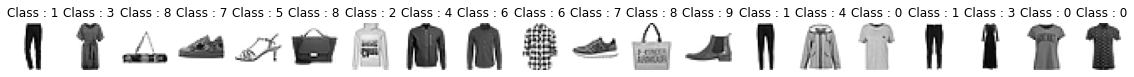

In [10]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [11]:
X_test = Test.values

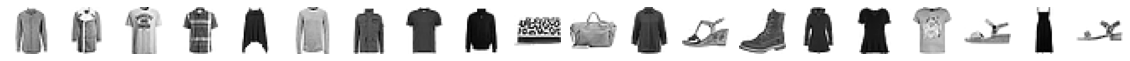

In [12]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

# 데이터 분리

In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torchvision


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1422, stratify = y, shuffle = True)

# 정규화
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)



# 함수 및 환경 설정

In [15]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [16]:
BATCH_SIZE = 128
EPOCHS = 2000

In [17]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [18]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False, num_workers=5)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False, num_workers=5)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, drop_last = False, num_workers = 5)

In [19]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 500, gamma=0.8)


  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    epoch_scheduler.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

In [20]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [21]:
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

# 제출

In [34]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #Conv 1
    #Convolutio
    self.cnn1= nn.Conv2d(in_channels=1, out_channels= 16, kernel_size=5, stride=1, padding=2)
    #Activation
    self.relu1 = nn.ReLU()
    self.conv1_bn = nn.BatchNorm2d(16)
    #MaxPool1
    self.MaxPool1 = nn.MaxPool2d(kernel_size=2)
    
    #Conv 2
    self.cnn2 = nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size=5,stride=1, padding=2)
    self.relu2 = nn.ReLU()
    self.conv2_bn = nn.BatchNorm2d(32)
    
    self.MaxPool2 = nn.MaxPool2d(kernel_size=2)
    
    self.cnn3 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=5,stride=1, padding=2)
    self.relu3 = nn.ReLU()
    self.conv3_bn = nn.BatchNorm2d(64)
    self.MaxPool3 = nn.MaxPool2d(kernel_size=2)
    
    self.fc1 = nn.Linear(576, 144)
    self.fc2 = nn.Linear(144,10)
  

    self._init_weight_()

  def _init_weight_(self):
    if isinstance(self, nn.Conv2d):
        nn.init.kaiming_uniform_(self.cnn1.weight)

    if isinstance(self, nn.Conv2d):
        nn.init.kaiming_uniform_(self.cnn2.weight)

    if isinstance(self, nn.Conv2d):
        nn.init.kaiming_uniform_(self.cnn3.weight)
    
    if isinstance(self,nn.Linear):
      nn.init.kaiming_uniform_(self.fc1.weight)

  def forward(self, x):
    x = x.reshape(-1,1,28,28)
    out = self.cnn1(x)
    # print(out.shape)
    out = self.conv1_bn(out)    
    # print(out.shape)
    out= self.relu1(out)
    # print(out.shape)
    out= self.MaxPool1(out)
    # print(out.shape)
    
    out= self.cnn2(out)
    # print(out.shape)
    out = self.conv2_bn(out)
    # print(out.shape)
    out = self.relu2(out)
    # print(out.shape)
    out = self.MaxPool2(out)
    # print(out.shape)
    
    out= self.cnn3(out)
    # print(out.shape)
    out = self.conv3_bn(out)
    # print(out.shape)
    out = self.relu3(out)
    # print(out.shape)
    out = self.MaxPool3(out)
    # print(out.shape)
    
    
    out = out.view(out.size(0), -1)
    # print(out.shape)
    out = self.fc1(out)
    # print(out.shape)
    out = self.fc2(out)
    # print(out.shape)
    
    return out
  

In [35]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (MaxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (MaxPool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=144, bias=True)
  (fc2): Linear(in_features=144, out_features=10, bias=True)
)


In [36]:
for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)

    output = model(image)
    print(output)
    break
    

torch.Size([128, 16, 28, 28])
torch.Size([128, 16, 28, 28])
torch.Size([128, 16, 28, 28])
torch.Size([128, 16, 14, 14])
torch.Size([128, 32, 14, 14])
torch.Size([128, 32, 14, 14])
torch.Size([128, 32, 14, 14])
torch.Size([128, 32, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 144])
torch.Size([128, 10])
tensor([[ 5.1248e-01, -1.1609e-03, -2.5310e-01,  ...,  1.4677e-01,
         -9.4860e-02,  1.9043e-01],
        [ 8.2933e-01,  9.8254e-02,  2.9076e-02,  ..., -1.1211e-01,
          4.1096e-01,  1.3836e-01],
        [ 1.3228e+00,  1.8650e-02, -4.1987e-01,  ...,  6.0412e-02,
          8.9961e-03,  7.5987e-01],
        ...,
        [ 6.5767e-01,  3.5145e-01, -2.2920e-01,  ...,  3.8882e-02,
         -9.7881e-02,  4.6572e-01],
        [ 4.6159e-01,  4.2059e-01, -1.5315e-01,  ..., -3.0992e-01,
         -1.1638e-01,  6.6988e-01],
        [ 6.2972e-01, -3.1652e-01, -3.3427e-01,  ..., 

In [77]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5618, 	Train Accuracy: 80.51 %, 	Val Loss: 0.3759, 	Val Accuracy: 86.27 % 

[EPOCH: 2], 	Train Loss: 0.3322, 	Train Accuracy: 88.04 %, 	Val Loss: 0.4168, 	Val Accuracy: 84.28 % 

[EPOCH: 3], 	Train Loss: 0.2785, 	Train Accuracy: 89.80 %, 	Val Loss: 0.2801, 	Val Accuracy: 90.26 % 

[EPOCH: 4], 	Train Loss: 0.2531, 	Train Accuracy: 90.84 %, 	Val Loss: 0.2896, 	Val Accuracy: 89.24 % 

[EPOCH: 5], 	Train Loss: 0.2273, 	Train Accuracy: 91.74 %, 	Val Loss: 0.2619, 	Val Accuracy: 90.61 % 

[EPOCH: 6], 	Train Loss: 0.2143, 	Train Accuracy: 92.12 %, 	Val Loss: 0.2553, 	Val Accuracy: 90.92 % 

[EPOCH: 7], 	Train Loss: 0.2003, 	Train Accuracy: 92.62 %, 	Val Loss: 0.3558, 	Val Accuracy: 86.88 % 

[EPOCH: 8], 	Train Loss: 0.1862, 	Train Accuracy: 93.14 %, 	Val Loss: 0.2398, 	Val Accuracy: 91.39 % 

[EPOCH: 9], 	Train Loss: 0.1763, 	Train Accuracy: 93.36 %, 	Val Loss: 0.3035, 	Val Accuracy: 90.05 % 

[EPOCH: 10], 	Train Loss: 0.1635, 	Train Accuracy: 93.91 %, 	Val Loss: 0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f372e0caa70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f372e0caa70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[EPOCH: 40], 	Train Loss: 0.0406, 	Train Accuracy: 98.66 %, 	Val Loss: 0.5994, 	Val Accuracy: 91.17 % 



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f372e0caa70>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f372e0caa70>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

[EPOCH: 41], 	Train Loss: 0.0687, 	Train Accuracy: 98.00 %, 	Val Loss: 0.6935, 	Val Accuracy: 90.92 % 

[EPOCH: 42], 	Train Loss: 0.0457, 	Train Accuracy: 98.49 %, 	Val Loss: 0.5486, 	Val Accuracy: 91.13 % 

[EPOCH: 43], 	Train Loss: 0.0292, 	Train Accuracy: 99.04 %, 	Val Loss: 0.6042, 	Val Accuracy: 90.31 % 

[EPOCH: 44], 	Train Loss: 0.0551, 	Train Accuracy: 98.41 %, 	Val Loss: 0.6469, 	Val Accuracy: 90.82 % 

[EPOCH: 45], 	Train Loss: 0.0749, 	Train Accuracy: 98.02 %, 	Val Loss: 0.6410, 	Val Accuracy: 90.51 % 

[EPOCH: 46], 	Train Loss: 0.0377, 	Train Accuracy: 98.78 %, 	Val Loss: 0.6391, 	Val Accuracy: 90.61 % 

[EPOCH: 47], 	Train Loss: 0.0373, 	Train Accuracy: 98.83 %, 	Val Loss: 0.7560, 	Val Accuracy: 90.38 % 

[EPOCH: 48], 	Train Loss: 0.0423, 	Train Accuracy: 98.68 %, 	Val Loss: 0.6573, 	Val Accuracy: 90.11 % 

[EPOCH: 49], 	Train Loss: 0.0216, 	Train Accuracy: 99.26 %, 	Val Loss: 0.7230, 	Val Accuracy: 90.87 % 

[EPOCH: 50], 	Train Loss: 0.0292, 	Train Accuracy: 99.07 %, 	Val

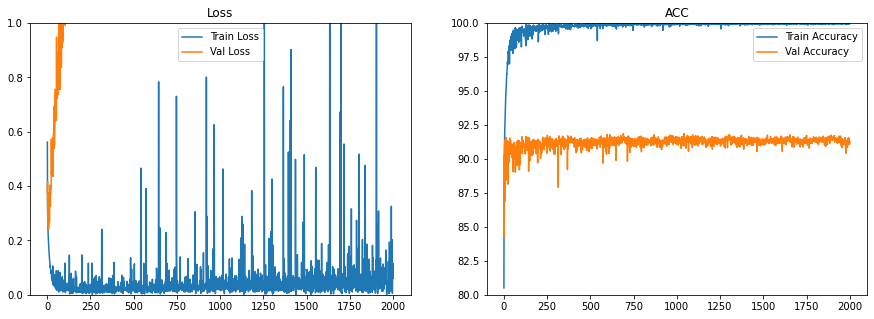

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

In [79]:
pred_label = pred(model, test_loader)

submission['label'] = pred_label

submission.to_csv(data_dir + 'basic_Model.csv', index = False)

submission.head()

,id,label
0,0,6
1,1,6
2,2,0
3,3,6
4,4,4
